#### Imports

In [1]:
import pandas as pd
import generate_dataset as gd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#### Loading or Generating dataset

In [2]:
csv_path = "synthetic_leads.csv"

try:
    df = pd.read_csv(csv_path)
    print("Loaded existing dataset")
except FileNotFoundError:
    df = gd.generate_dataset(n_samples=5000, save_csv=True, csv_path=csv_path)
    print("CSV not found. Generated new dataset.")

print(df.head())

Loaded existing dataset
   company_size industry  tech_stack_keywords  page_visits  intent_signal  \
0           861  Finance          SQL, NodeJS           78           0.28   
1          3773  Finance               Python            4           0.44   
2          3093     Tech  NodeJS, AWS, Python            9           0.09   
3           467   Health               Python           25           0.89   
4          4427  Finance          SQL, NodeJS           47           0.51   

   historical_conversion_rate  converted  
0                        0.06          1  
1                        0.67          0  
2                        0.41          0  
3                        0.49          1  
4                        0.34          1  


#### Feature-target split

In [3]:
X = df.drop('converted', axis=1)
y = df['converted']

#### Preprocessing and one hot encoding of categorical features

In [4]:
categorical_cols = ['industry', 'tech_stack_keywords']
numeric_cols = ['company_size', 'page_visits', 'intent_signal', 'historical_conversion_rate']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)
X_encoded = preprocessor.fit_transform(X)

#### Train–Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#### Model Init (XGBoost)

In [6]:
#Class imbalance weighting
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

#init
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

In [7]:
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#### Predictions

In [8]:
y_pred = xgb_model.predict(X_test)

#### Evaluation

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       232
           1       1.00      0.98      0.99       768

    accuracy                           0.98      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000



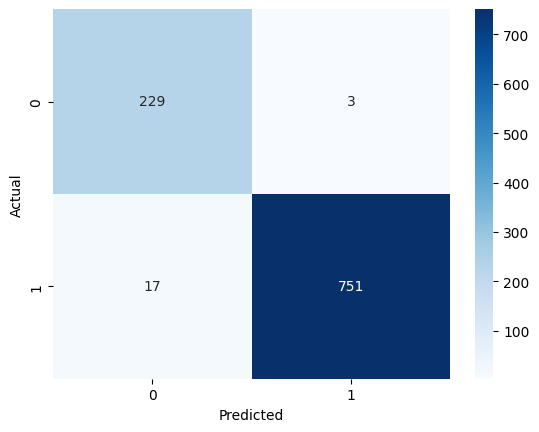

In [9]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Feature importance (raw)

In [10]:
importance = xgb_model.feature_importances_
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)) + numeric_cols

feature_importance_df_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print(feature_importance_df_xgb.head(10))

                        feature  importance
264                 page_visits    0.588722
265               intent_signal    0.175928
266  historical_conversion_rate    0.173905
153  tech_stack_keywords_Python    0.018437
4                 industry_Tech    0.010014
0            industry_Education    0.009567
263                company_size    0.008057
2               industry_Health    0.006892
3               industry_Retail    0.006598
190   tech_stack_keywords_React    0.001880


#### Feature importance (visualized)

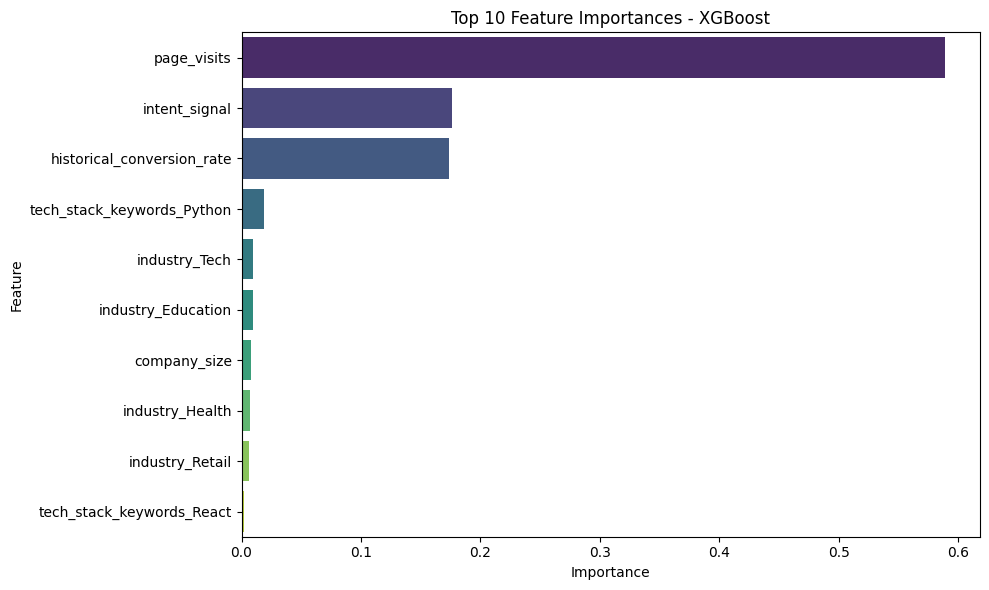

In [11]:
top_features_xgb = feature_importance_df_xgb.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_features_xgb, 
    hue='feature',
    dodge=False,
    palette='viridis', 
    legend=False
)
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Distribution of lead scores (Bonus)

      company_size   industry    tech_stack_keywords  page_visits  \
1074          3311    Finance                    AWS           38   
3061          3120    Finance                 NodeJS           35   
2328          2548       Tech  React, Kotlin, Python           43   
3008          2835       Tech                  React           37   
4309          3295  Education    AWS, Kotlin, Python           35   
928           2646       Tech    AWS, Python, NodeJS           35   
3444          2838    Finance                 NodeJS           50   
1545          2769    Finance         AWS, Java, SQL           34   
1285          2033    Finance                 Kotlin           38   
2091          3037       Tech     Python, React, SQL           54   

      intent_signal  historical_conversion_rate  converted  lead_score  
1074           0.96                        0.86          1    0.999994  
3061           0.86                        0.78          1    0.999994  
2328           0.92  

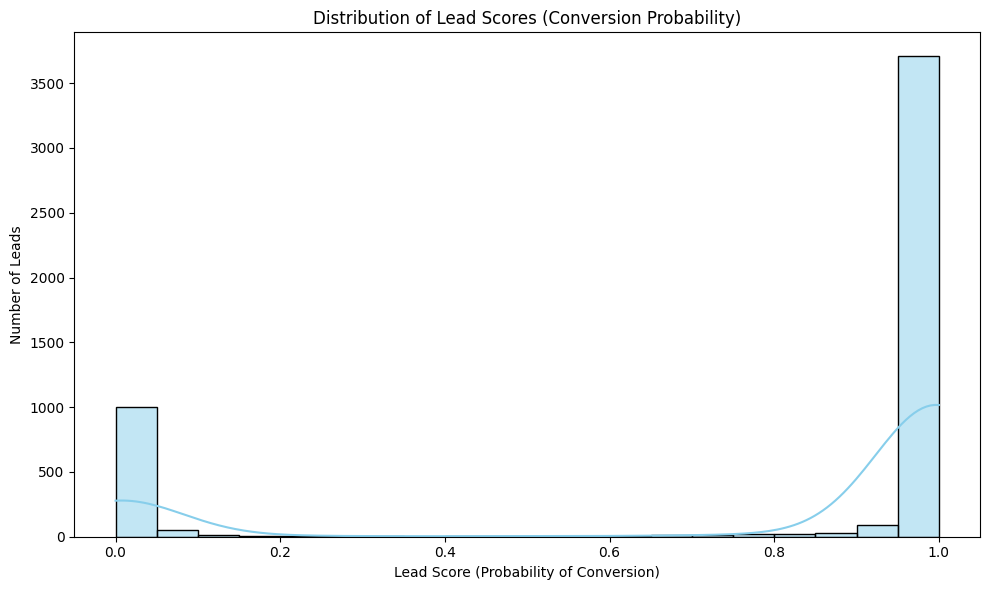

In [12]:
lead_scores = xgb_model.predict_proba(X_encoded)[:, 1]

df['lead_score'] = lead_scores

df_sorted = df.sort_values(by='lead_score', ascending=False)
print(df_sorted.head(10))

plt.figure(figsize=(10,6))
sns.histplot(df['lead_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Lead Scores (Conversion Probability)")
plt.xlabel("Lead Score (Probability of Conversion)")
plt.ylabel("Number of Leads")
plt.tight_layout()
plt.show()

Random Forest was also tested, but XGBoost achieved slightly higher accuracy and better class balance, so it was chosen for final scoring.